In [1]:
# before import this, run "pip install -r requirements.txt"
# needed libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import kagglehub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score
from wordcloud import WordCloud
from sklearn.decomposition import PCA

In [2]:
# define dataset paths
# kaggle API download
path = kagglehub.dataset_download("abisheksudarshan/topic-modeling-for-research-articles")
dataset_path = "/root/.cache/kagglehub/datasets/abisheksudarshan/topic-modeling-for-research-articles/versions/7"
# list files in the dataset directory
files = os.listdir(dataset_path)
print("Available files:", files)

100%|██████████| 7.24M/7.24M [00:00<00:00, 30.6MB/s]

Extracting files...


Available files: ['Train.csv', 'Test.csv', 'sample_sub.csv', 'Tags.csv']


In [3]:
# as we can see, there are 4 available .csv files: Train.csv, Test.csv, sample_sub.csv, Tags.csv
# load datasets
df_train = pd.read_csv(os.path.join(dataset_path, "Train.csv"))
df_test = pd.read_csv(os.path.join(dataset_path, "Test.csv"))
df_tags = pd.read_csv(os.path.join(dataset_path, "Tags.csv"))
df_sample_sub = pd.read_csv(os.path.join(dataset_path, "sample_sub.csv"))

# check dataset structure make sure we can adjust column names accordingly
# prepreocessing function expects "ABSTRACT" column
# check dataset structure for Train.csv
# Define a function for cleaner dataset inspection
def inspect_dataset(name, df):
    print("="*40)
    print(f"Dataset: {name}")
    print("="*40)
    print(f"Columns: {list(df.columns)}\n")
    print(df.head(), "\n")

# Inspect all datasets
inspect_dataset("Train.csv", df_train)
inspect_dataset("Test.csv", df_test)
inspect_dataset("Tags.csv", df_tags)
inspect_dataset("Sample_Sub.csv", df_sample_sub)


Dataset: Train.csv
Columns: ['id', 'ABSTRACT', 'Computer Science', 'Mathematics', 'Physics', 'Statistics', 'Analysis of PDEs', 'Applications', 'Artificial Intelligence', 'Astrophysics of Galaxies', 'Computation and Language', 'Computer Vision and Pattern Recognition', 'Cosmology and Nongalactic Astrophysics', 'Data Structures and Algorithms', 'Differential Geometry', 'Earth and Planetary Astrophysics', 'Fluid Dynamics', 'Information Theory', 'Instrumentation and Methods for Astrophysics', 'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory', 'Optimization and Control', 'Representation Theory', 'Robotics', 'Social and Information Networks', 'Statistics Theory', 'Strongly Correlated Electrons', 'Superconductivity', 'Systems and Control']

     id                                           ABSTRACT  Computer Science  \
0  1824  a ever-growing datasets inside observational a...                 0   
1  3094  we propose the framework considering optimal $...                

In [6]:
# initialize stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# download the punkt_tab data
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# function to check dataset structure before processing
def check_column_exists(df, name, filename):
    if name not in df.columns:
        raise ValueError(f"Column '{name}' not found. Check dataset structure for {filename}.")

# check if 'ABSTRACT' exists in both datasets. only Train.csv and Test.csv has "ABSTRACT" column
check_column_exists(df_train, "ABSTRACT", "Train.csv")
check_column_exists(df_test, "ABSTRACT", "Test.csv")

# preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # handle non-string values
        return ""

    text = text.lower()  # convert to lowercase
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # keep only letters and spaces
    tokens = word_tokenize(text)  # tokenization
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # lemmatization
    return " ".join(tokens)

# apply preprocessing to both Train.csv and Test.csv
df_train["processed_text"] = df_train["ABSTRACT"].apply(preprocess_text)
df_test["processed_text"] = df_test["ABSTRACT"].apply(preprocess_text)

# select a few sample abstracts for display
sample_train = df_train[["ABSTRACT", "processed_text"]].head(3)
sample_test = df_test[["ABSTRACT", "processed_text"]].head(3)

# display processed results for Train.csv
print("\n" + "="*40)
print("Processed text samples from Train.csv")
print("="*40)
for i, row in sample_train.iterrows():
    print(f"**Original abstract {i+1} (Train.csv):**\n{row['ABSTRACT']}\n")
    print(f"**Processed abstract {i+1} (Train.csv):**\n{row['processed_text']}\n")
    print("-"*80)

# Display processed results for Test.csv
print("\n" + "="*40)
print("Processed text samples from Test.csv")
print("="*40)
for i, row in sample_test.iterrows():
    print(f"**Original abstract {i+1} (Test.csv):**\n{row['ABSTRACT']}\n")
    print(f"**Processed abstract {i+1} (Test.csv):**\n{row['processed_text']}\n")
    print("-"*80)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Processed text samples from Train.csv
**Original abstract 1 (Train.csv):**
a ever-growing datasets inside observational astronomy have challenged scientists inside many aspects, including an efficient and interactive data exploration and visualization. many tools have been developed to confront this challenge. however, they usually focus on displaying a actual images or focus on visualizing patterns within catalogs inside the predefined way. inside this paper we introduce vizic, the python visualization library that builds a connection between images and catalogs through an interactive map of a sky region. vizic visualizes catalog data over the custom background canvas with the help of a shape, size and orientation of each object inside a catalog. a displayed objects inside a map are highly interactive and customizable comparing to those inside a images. these objects should be filtered by or colored by their properties, such as redshift and magnitude. they also should be sub-selected

In [7]:
# combine train and test data for vectorization
all_texts = pd.concat([df_train["processed_text"], df_test["processed_text"]], ignore_index=True)

# apply TF-IDF vectorization (with max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(all_texts)

# convert to DataFrame for easy viewing
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# display first few rows
print("\n" + "="*40)
print("TF-IDF feature representation (Top Words)")
print("="*40)
print(tfidf_df.head())

# Show top 10 words based on their TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
top_words = tfidf_df.mean().sort_values(ascending=False).head(10)
print("\nTop 10 words by Average TF-IDF Score:")
print(top_words)


TF-IDF feature representation (Top Words)
    aa   ab  abc  abelian  abell  ability  able  abnormal  abrupt  absence  \
0  0.0  0.0  0.0      0.0    0.0      0.0   0.0       0.0     0.0      0.0   
1  0.0  0.0  0.0      0.0    0.0      0.0   0.0       0.0     0.0      0.0   
2  0.0  0.0  0.0      0.0    0.0      0.0   0.0       0.0     0.0      0.0   
3  0.0  0.0  0.0      0.0    0.0      0.0   0.0       0.0     0.0      0.0   
4  0.0  0.0  0.0      0.0    0.0      0.0   0.0       0.0     0.0      0.0   

   ...  yield  yielding  young   yr  zeeman  zero  zeta  zhang   zn  zone  
0  ...    0.0       0.0    0.0  0.0     0.0   0.0   0.0    0.0  0.0   0.0  
1  ...    0.0       0.0    0.0  0.0     0.0   0.0   0.0    0.0  0.0   0.0  
2  ...    0.0       0.0    0.0  0.0     0.0   0.0   0.0    0.0  0.0   0.0  
3  ...    0.0       0.0    0.0  0.0     0.0   0.0   0.0    0.0  0.0   0.0  
4  ...    0.0       0.0    0.0  0.0     0.0   0.0   0.0    0.0  0.0   0.0  

[5 rows x 5000 columns]

Top 10


K-Means Clustering results
                                            ABSTRACT  cluster
0  a ever-growing datasets inside observational a...        0
1  we propose the framework considering optimal $...        0
2  nanostructures with open shell transition meta...        3
3  stars are self-gravitating fluids inside which...        3
4  deep neural perception and control networks ar...        1
5  analyzing job hopping behavior was important c...        0
6  a need to reason about uncertainty inside larg...        0
7  period approximation was one of a central topi...        0
8  nowadays data compressors are applied to many ...        0
9  inside this work, the many-body potential of n...        3


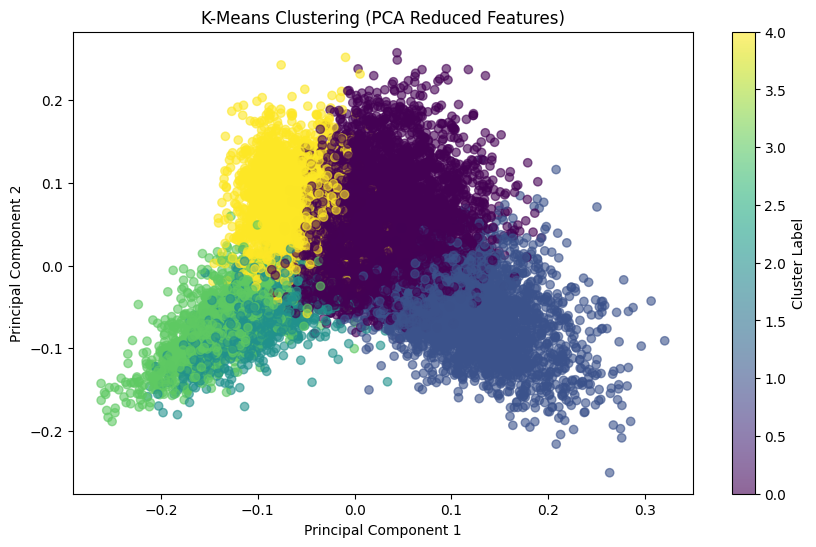

In [8]:
# K-Means Clustering (let num_clusters=5)
num_clusters = 5

# apply K-Means clustering on the TF-IDF matrix
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# K-Means is an unsupervised learning algorithm so clustering on train data only
df_train["cluster"] = kmeans.fit_predict(tfidf_matrix[:len(df_train)])

# display cluster assignments
print("\n" + "="*40)
print("K-Means Clustering results")
print("="*40)
print(df_train[["ABSTRACT", "cluster"]].head(10))

# reduce TF-IDF dimensions from 5000 to 2 for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(tfidf_matrix[:len(df_train)])

# scatter plot of clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df_train["cluster"], cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster Label")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering (PCA Reduced Features)")
plt.show()

- each dot = a research abstract
- clusters (colors) = similar research topic
- PCA helps visualize high-dimensional data in 2D spaces

- if K-Means correctly grouped the abstract, each color shows a distinct topic area
- some points blend into each other meaning topics may have some similarities
- some clusters are dense, while others more spread out suggesting some topics are more distinct than others

In [9]:
# Compute Silhouette Score only for train data
train_tfidf_matrix = tfidf_matrix[:len(df_train)]  # slice to match df_train

if len(set(df_train["cluster"])) > 1:
    silhouette_avg = silhouette_score(train_tfidf_matrix, df_train["cluster"])
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Interpretation of clustering quality
    if silhouette_avg > 0.5:
        print("Good clustering: clusters are well-separated.")
    elif silhouette_avg > 0.25:
        print("Moderate clustering: some overlap between clusters.")
    else:
        print("Poor clustering: clusters may not be well defined.")
else:
    print("Cannot compute Silhouette Score: only one cluster detected.")

Silhouette Score: 0.0077
Poor clustering: clusters may not be well defined.


it means the clusters are poorly separated and overlapping. to improve:


*   Elbow Method (finding best K)
*   increase max_features=10000 or 20000 for TF-IDF



In [10]:
# TF-IDF when increase max_features to 10000
# different TF-IDF settings
tfidf_settings = {
    "Default": TfidfVectorizer(max_features=5000),  # Standard unigram
    "Increased_Vocab_10K": TfidfVectorizer(max_features=10000),  # More words
    "Increased_Vocab_20K": TfidfVectorizer(max_features=20000),  # More words
    "Bigrams": TfidfVectorizer(max_features=5000, ngram_range=(1,2)),  # Includes bigrams
    "Trigrams": TfidfVectorizer(max_features=5000, ngram_range=(1,3))   # Includes trigrams
}

# Store Silhouette Scores
silhouette_scores = {}

# Number of clusters
num_clusters = 5

for name, vectorizer in tfidf_settings.items():
    print(f"\n===== {name} =====")

    # Fit TF-IDF on train data
    train_tfidf_matrix = vectorizer.fit_transform(df_train["processed_text"])

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df_train["cluster"] = kmeans.fit_predict(train_tfidf_matrix)

    # Compute Silhouette Score (only if multiple clusters exist)
    if len(set(df_train["cluster"])) > 1:
        silhouette_avg = silhouette_score(train_tfidf_matrix, df_train["cluster"])
        silhouette_scores[name] = silhouette_avg
        print(f"Silhouette Score: {silhouette_avg:.4f}")

        # Interpretation of clustering quality
        if silhouette_avg > 0.5:
            print("Good clustering: clusters are well-separated.")
        elif silhouette_avg > 0.25:
            print("Moderate clustering: some overlap between clusters.")
        else:
            print("Poor clustering: clusters may not be well defined.")
    else:
        print("Cannot compute Silhouette Score: only one cluster detected.")

    # Display top 10 words by average TF-IDF score
    feature_names = vectorizer.get_feature_names_out()
    mean_tfidf = train_tfidf_matrix.mean(axis=0).A1  # Convert sparse matrix to array
    sorted_features = sorted(zip(feature_names, mean_tfidf), key=lambda x: x[1], reverse=True)

    print("Top 10 words (by TF-IDF score):")
    for word, score in sorted_features[:10]:
        print(f"{word}: {score:.4f}")


===== Default =====
Silhouette Score: 0.0076
Poor clustering: clusters may not be well defined.
Top 10 words (by TF-IDF score):
inside: 0.0580
considering: 0.0401
model: 0.0298
method: 0.0271
network: 0.0223
data: 0.0218
algorithm: 0.0195
problem: 0.0193
learning: 0.0186
system: 0.0178

===== Increased_Vocab_10K =====
Silhouette Score: 0.0065
Poor clustering: clusters may not be well defined.
Top 10 words (by TF-IDF score):
inside: 0.0536
considering: 0.0370
model: 0.0278
method: 0.0253
network: 0.0209
data: 0.0203
algorithm: 0.0182
problem: 0.0181
learning: 0.0175
system: 0.0164

===== Increased_Vocab_20K =====
Silhouette Score: 0.0059
Poor clustering: clusters may not be well defined.
Top 10 words (by TF-IDF score):
inside: 0.0511
considering: 0.0352
model: 0.0266
method: 0.0242
network: 0.0200
data: 0.0194
problem: 0.0173
algorithm: 0.0173
learning: 0.0168
system: 0.0157

===== Bigrams =====
Silhouette Score: 0.0078
Poor clustering: clusters may not be well defined.
Top 10 words (b

since the Silhouette Scores are very low (~0.007) across TF-IDF settings. using Elbow Method to find the best k in K-Means Clustering

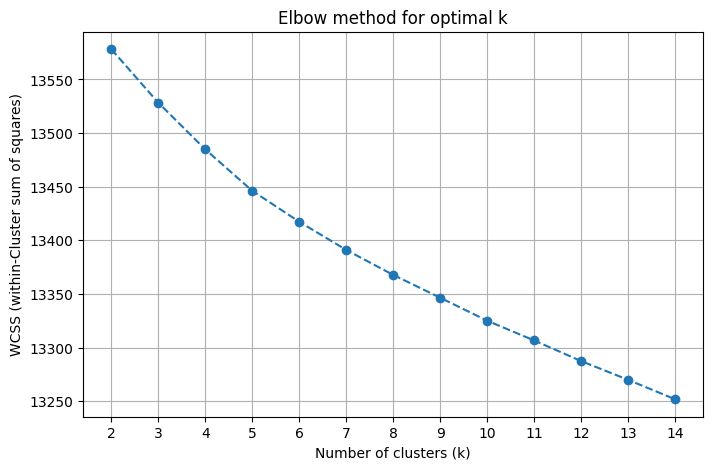

In [11]:
# TF-IDF Vectorization (using Best Settings from Previous Runs)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # Bigram + 10K vocab
train_tfidf_matrix = vectorizer.fit_transform(df_train["processed_text"])

# trying different values of k
k_values = range(2, 15)  # checking clusters from 2 to 15
wcss = []  # within-Cluster Sum of Squares (WCSS)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_tfidf_matrix)
    wcss.append(kmeans.inertia_)  # inertia = Sum of squared distances to nearest cluster center

# plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker="o", linestyle="--")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (within-Cluster sum of squares)")
plt.title("Elbow method for optimal k")
plt.xticks(k_values)
plt.grid()
plt.show()

In [12]:
# set the optimal number of clusters (update this after checking the elbow plot)
optimal_k = 6

# apply K-Means Clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_train["cluster"] = kmeans.fit_predict(train_tfidf_matrix)

# compute Silhouette Score (only if there is more than one cluster)
if len(set(df_train["cluster"])) > 1:
    silhouette_avg = silhouette_score(train_tfidf_matrix, df_train["cluster"])
    print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.4f}")

    # Interpretation of clustering quality
    if silhouette_avg > 0.5:
        print("Good clustering: clusters are well-separated.")
    elif silhouette_avg > 0.25:
        print("Moderate clustering: some overlap between clusters.")
    else:
        print("Poor clustering: clusters may not be well defined.")
else:
    print("Cannot compute Silhouette Score: only one cluster detected.")

Silhouette Score for k=6: 0.0063
Poor clustering: clusters may not be well defined.


after finding optimal k using elbow method and use best settings for tf-idf and the clustering is still poor, it likely means that the dataset does not have well-separated clusters:
- high overlap in topics
- k-means may not be the best algorithm


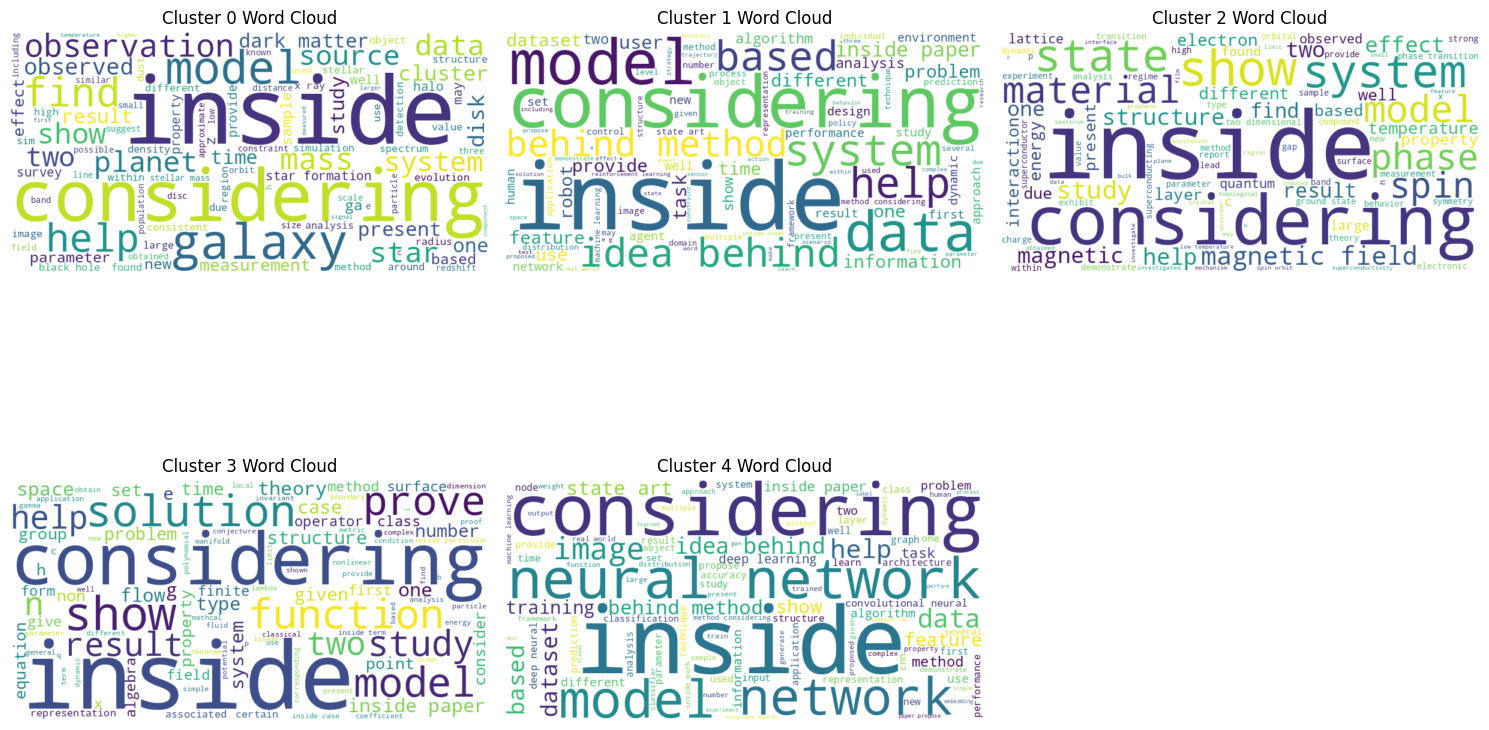

In [13]:
# word clouds for each topic
# set number of rows and columns for subplot grid
rows = (num_clusters // 3) + 1
cols = min(num_clusters, 3)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# flatten axes for easy iteration (handles cases where num_clusters < grid size)
axes = axes.flatten() if num_clusters > 1 else [axes]

for i in range(num_clusters):
    cluster_words = " ".join(df_train[df_train["cluster"] == i]["processed_text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(cluster_words)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Cluster {i} Word Cloud")

# hide unused subplots if num_clusters < total grid slots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- the word "inside" apears in almost every clusters
- "considering", "method", "result", "data", "algorithm" and "problem" also show up frequently across different clusters
> clusters are not well-separated, the model struggles to distinguish distinct topics
- cluster 1: words like "agent", "policy", "reinforcement", "task" focus on reinforcement learning or AI agents
- cluster 4: words like "network", "graph", "structure", "node" focus on graph theory or network analysis
- cluster 3: words like "equation", "solution", "system", "function" focus on mathematical modeling
> cluster 0 and 2 have broad, overlapping words don't clearly differentiate topics
- TF-IDF is not capturing strong topic distinction - common words dominate
> Try BERT embedding